# **Reinforcement Learning**
<img align="right" src="https://vitalflux.com/wp-content/uploads/2020/12/Reinforcement-learning-real-world-example.png">

- In reinforcement learning, your system learns how to interact intuitively with the environment by basically doing stuff and watching what happens.

if you need the last version of gym use block of code below:

```sh
!pip uninstall gym -y
!pip install gym
```
<br>

And here is gymnasium version:

```python
gymnasium.__version__
```
1.2.0

In [ ]:
# !pip install -U gym==0.25.2
!pip install swig
!pip install gymnasium[atari]
!pip install gymnasium[box2d]
!pip install gymnasium[accept-rom-license]
# !pip install autorom[accept-rom-license]

In [2]:
import random
import math
from tqdm.auto import tqdm
from collections import defaultdict, deque
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from IPython.core.display import HTML
from base64 import b64encode
from gym.wrappers import record_video, record_episode_statistics
from gym.wrappers import RecordVideo, RecordEpisodeStatistics

import torch
from torch.autograd import Variable

import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

import warnings
warnings.filterwarnings('ignore')

In [3]:
def display_video(episode=0, video_width=600):
    """
    Displays a video from a specified episode with customizable width.

    Args:
        episode (int): The episode number to load the video for. Defaults to 0.
        video_width (int): The width of the video player in pixels. Defaults to 600.

    Returns:
        IPython.display.HTML: An HTML video element that can be rendered in Jupyter notebooks.

    Note:
        - The function expects video files to be in './video/' directory with naming format 'rl-video-episode-{N}.mp4'
        - Videos are base64 encoded and embedded directly in the HTML for display
    """
    # Construct the path to the video file based on episode number
    video_path = f"./video/rl-video-episode-{episode}.mp4"

    # Read the video file as binary data
    video_file = open(video_path, "rb").read()

    # Encode the binary video data as base64 string
    decoded = b64encode(video_file).decode()

    # Create a data URL for the video
    video_url = f"data:video/mp4;base64,{decoded}"

    # Return an HTML video element with the embedded video
    return HTML(f"""<video width="{video_width}"" controls><source src="{video_url}"></video>""")

def create_env(name, render_mode="rgb_array", record=False, eps_record=50, video_folder='./video'):
    """
    Creates and configures a Gym environment with optional video recording and statistics tracking.

    Args:
        name (str): Name of the Gym environment to create (e.g., 'CartPole-v1')
        render_mode (str): Rendering mode - "human", "rgb_array", or "ansi". Defaults to "rgb_array"
        record (bool): Whether to record videos of the environment. Defaults to False
        eps_record (int): Record a video every N episodes (when record=True). Defaults to 50
        video_folder (str): Directory to save recorded videos. Defaults to './video'

    Returns:
        gym.Env: Configured Gym environment wrapped with recording and statistics tracking

    Note:
        - When record=True, videos will be saved in the specified folder with automatic naming
        - The environment is always wrapped with episode statistics tracking
    """
    # Create base Gym environment with specified render mode
    env = gym.make(name, render_mode=render_mode)

    # Optionally wrap environment with video recorder
    if record:
        # Record video every eps_record episodes (trigger function)
        env = RecordVideo(env, video_folder=video_folder,
                         episode_trigger=lambda x: x % eps_record == 0)

    # Always wrap environment with episode statistics tracker
    env = RecordEpisodeStatistics(env)

    return env

def show_reward(total_rewards):
    """
    Plots the progression of rewards across episodes using matplotlib.

    Args:
        total_rewards (list or array-like): A sequence of reward values obtained per episode.

    Displays:
        A line plot showing the reward trend over episodes with:
        - X-axis: Episode number
        - Y-axis: Reward value

    Note:
        - This function immediately displays the plot using plt.show()
        - The plot uses default matplotlib styling
        - Useful for visualizing training progress in reinforcement learning
    """
    # Create line plot of reward values
    plt.plot(total_rewards)

    # Label the x-axis as 'Episode'
    plt.xlabel('Episode')

    # Label the y-axis as 'Reward'
    plt.ylabel('Reward')

    # Display the plot
    plt.show()

The **TD** method is able to update the Q-function on the fly during an episode, which is considered an advancement on the **MC** method. However, the TD method is still not sufficiently scalable for problems with many states and/or actions. It will be extremely slow at learning too many values for individual pairs of states and actions using the TD method.

Methods we have seen so far work well when we have a tabular representation for each state, that is, when we represent value function with a lookup table., This is not reasonable on most cases:
- In Large state spaces: There are too many states and/or actions to store in memory (f.i. Backgammon: 1020 states, Go 10170 states)
- In continuous state spaces (f.i. robotic examples)

We will focus on **function approximation**, which can overcome the scaling issues in the TD method.
1. developing the linear function estimator.
2. incorporate it into the Q-learning and SARSA algorithms.
3. improve the Q-learning algorithm using experience replay.
4. experiment with using neural works as a function estimator

<br>

- **What Is Function Approximation**

Function approximation is a technique for estimating an unknown underlying function using historical or available observations from the domain.

- Function approximation is often related to a Markov decision process (MDP) which consists of an agent and various states.

- Artificial neural networks learn to approximate a function.

## **Estimating Q-functions with gradient descent approximation**

we will develop FA algorithms to solve environments with continuous state variables. We will begin by approximating Q-functions using linear functions and gradient descent.

The main idea of FA is to use a set of features to estimate Q values. This is extremely useful for processes with a large state space where the Q table becomes huge. There are several ways to map the features to the Q values; for example, linear approximations that are linear combinations of features and neural networks. With linear approximation, the state-value function for an action is expressed by a weighted sum of the features:

<br>

$$
\large V(a) = \theta_1F_1(s) + \theta_2F_2(s) + ... + \theta_nF_n(s)
$$

<br>

> Here, $F_1(s), F_2(s), ……, F_n(s) $ is a set of features given the input state, $s$ <br>
$θ_1, θ_2,..., θ_n$ are the weights applied to corresponding features. Or we can put it as $V(s)=θF(s)$.

<br>

As we have seen this in the TD method, we have the following formula to compute the future states:

---
<br>

$$
\large V(s_t) \leftarrow V_{s_t} + \alpha[r + \gamma V_{s_{t+1}} - V_{s_t}] \\
\large \delta = r + \gamma V_{s_{t+1}} - V_{s_t} \\
\large \text{so:} \\
\large V_{s_t} \leftarrow V_{s_t} + \alpha \delta
$$

<br>

---

<br>

$$
\large Q(s, a) \leftarrow Q(s, a) + \alpha[r + \gamma Q(s', a') - Q(s, a)] \\
\large \delta = r + \gamma Q(s', a') - Q(s, a) \\
\large \text{so:} \\
\large Q(s, a) \leftarrow Q(s, a) + \alpha \delta
$$

<br>

---

This is in the exact form of gradient descent. Hence:
- the goal of learning is to find the optimal weights, $θ$, to best approximate the state-value function for each possible action.
- The loss function we are trying to minimize in this case is similar to that in a regression problem, which is the **mean squared error** between the actual value and the estimated value.

After each step in an episode, we have a new estimation of the true state value, and we move the weights, $θ$, a step toward their optimal value.


**Note**: One more thing to note is the feature set, $F(s)$, given the input state, s. A good feature set is one that can capture the dynamics of different inputs. Typically, we can generate a set of features with a set of **Gaussian functions** under various parameters, including mean and standard deviation.

### **Estimator**
1. Initialize constructor:
    - Inpute: It takes in three parameters, the number of features, n_feat; the number of states; and the number of actions.

    - first generates a set of coefficients, w and b, for the feature function F(s) from Gaussian distributions, which we will define in the class.

    -  then initializes n_action linear models, where each model corresponds to an action, and n_action **optimizers**, accordingly.

    - For the linear model, we use the Linear module from PyTorch. It takes in n_feat units and generates one output, which is the predicted state-value for an action.

2. Next, we develop the function to map the state space to the feature space based on w and b:
    - The feature of a state, s, is generated as follows:
    - Use cosine transformation to ensure that the feature is in the range of [-1, 1] despite the value of an input state.

$$
F(s) = \sqrt{\frac{2}{\small \textit{number of feature}}} * cos(ws + b)
$$

3. Since we've defined model and feature generation, we now develop the training method, which updates the linear models with a data point:
    - Inpute: state, action, target value
    - First converts the state to feature space with the `_get_feature` method.
    - The resulting features are then fed into the current linear model of the given action, a.
    - The predictive result, along with the target value, is used to compute the loss and gradients.
    - The weights, θ, are then updated via backpropagation.

4. The next operation involves predicting the state-value for each action given a state using the current models:

---
**explanation:**

- Gaussian Random Features:
The Gaussian function is used here to approximate a Radial Basis Function (RBF) kernel. Instead of explicitly calculating pairwise kernel values, we map the input state into a high-dimensional feature space using random projections.

---
1. The weights $w$ are sampled from a Gaussian distribution with a mean of 0 and variance proportional to $1/\sigma^2$.This ensures the weights mimic the kernel’s smoothness.

$$
w \sim \mathcal{N}(0, \frac{1}{\sigma^2})
$$


> Here is Gaussian distribution formula:
$$
f(x) = \frac{1}{\sigma\sqrt{2\pi}} e^{-\frac{1}{2}\left(\frac{x - \mu}{\sigma}\right)^2}
$$
$\mu$ is the mean <br>
$\sigma$ is the standard deviation

<br>

2. The biases $b$ are sampled uniformly from $[0, 2\pi]$. This ensures a phase shift for the cosine mapping.

$$
b \sim \mathcal{U}(0, 2\pi)
$$

> Here is Uniform distribution over $[a,b]$ formula:
$$
f(x) = \begin{cases}
\frac{1}{b - a} & \text{if } a \leq x \leq b \\
0 & \text{otherwise}
\end{cases}
$$

---

- The Feature Mapping Function (`_get_feature`):<br>
The `_get_feature` function transforms the raw input state ($s$) into a high-dimensional feature vector.

$$
\phi(s) = \sqrt{\frac{2}{n_{feat}}} \cdot \cos(w \cdot s + b)
$$

> $w$: The Gaussian weights (from `_gaussian_function`).<br>
$b$: The biases (from _gaussian_function).<br>
$\sqrt{\frac{2}{n_{feat}}}$: A normalization factor.

In [4]:
class Estimator():

    def __init__(self, n_feat, n_state, n_action, lr=0.05):
        # Initialize the estimator with key parameters
        self.n_state = n_state  # Number of states in the environment
        self.n_action = n_action  # Number of possible actions
        self.n_feat = n_feat  # Number of features used for representation
        self.lr = lr  # Learning rate for optimization

        # Generate Gaussian random features
        self.w, self.b = self._gaussian_function()

        # Create separate models and optimizers for each action
        self.models = []  # List to store models for each action
        self.optimizers = []  # List to store optimizers for each model

        # Define the loss function (Mean Squared Error for regression)
        self.criterion = torch.nn.MSELoss()

        # Initialize a linear regression model and optimizer for each action
        for _ in range(self.n_action):
            model = torch.nn.Linear(self.n_feat, 1)  # Linear model for action
            optimizer = torch.optim.SGD(model.parameters(), self.lr)  # SGD optimizer
            self.models.append(model)  # Append the model to the list
            self.optimizers.append(optimizer)  # Append the optimizer to the list

    def _gaussian_function(self, sigma=.2):
        """
        Generate Gaussian random weights and biases for feature mapping.
        Args:
            sigma: Controls the variance of the Gaussian distribution.
        Returns:
            w: Weight matrix for Gaussian features.
            b: Bias vector for Gaussian features.
        """
        torch.manual_seed(7)  # Set seed for reproducibility
        w = torch.randn((self.n_state, self.n_feat)) * (1 / sigma)  # Random weights from a normal distribution
        b = torch.rand(self.n_feat) * 2 * math.pi  # Random biases from a uniform distribution in [0, 2π]
        return w, b

    def _get_feature(self, s):
        """
        Map a given state to a Gaussian random feature representation.
        Args:
            s: State vector.
        Returns:
            Transformed feature vector.
        """
        arc = torch.matmul(torch.tensor(s).float(), self.w) + self.b  # Compute projection + bias (Matrix product of two tensors)
        return (2 / self.n_feat) ** .5 * torch.cos(arc)  # Apply cosine transformation

    def update(self, s, a, y):
        """
        Update the model for a given state, action, and target value.
        Args:
            s: State vector.
            a: Action index (integer).
            y: Target value (scalar).
        """
        features = Variable(self._get_feature(s))  # Compute feature representation
        y_pred = self.models[a](features)  # Predict the target value for the given action
        loss = self.criterion(y_pred, Variable(torch.Tensor([y])))  # Compute MSE loss

        self.optimizers[a].zero_grad()  # Zero out gradients
        loss.backward()  # Backpropagate the error
        self.optimizers[a].step()  # Update the model parameters

    def predict(self, s):
        """
        Predict Q-values for all actions for a given state.
        Args:
            s: State vector.
        Returns:
            Tensor of predicted Q-values for all actions.
        """
        features = self._get_feature(s)  # Compute feature representation
        with torch.no_grad():  # Disable gradient calculation
            return torch.tensor([model(features) for model in self.models])  # Predict for all actions

In [5]:
# Check the Estimator
estimator = Estimator(10, 2, 1)
s1 = [0.5, 0.1]
estimator._get_feature(s1)

tensor([ 0.4198, -0.4458, -0.4072, -0.1476, -0.0998, -0.4301, -0.3951, -0.3647,
        -0.4303,  0.4295])

In [6]:
# Train the estimator on a list of states and target state-values
s_list = [[1, 2], [2, 2], [3, 4], [2, 3], [2, 1]]
target_list = [1, 1.5, 2, 2, 1.5]
estimator = Estimator(10, 2, 1)
for s, target in zip(s_list, target_list):
    feature = estimator._get_feature(s)
    estimator.update(s, 0, target)

print(estimator.predict([0.5, 0.1]))
print('----------')
print(estimator.predict([2, 3]))

tensor([0.5808])
----------
tensor([0.9981])


## **Mountain Car Environment**

<img width="400" align="right" src="https://www.gymlibrary.dev/_images/mountain_car.gif">


<br>

<table>
<tr>
    <td><font size="3">Action Space</td>
    <td><font size="3">Discrete(3)</td>
</tr>
<tr>
    <td><font size="3">Observation Shape</td>
    <td><font size="3">(2,))</td>
</tr>
<tr>
    <td><font size="3">Observation High</td>
    <td><font size="3">[0.6,  0.07]</td>
</tr>
<tr>
    <td><font size="3">Observation Low</td>
    <td><font size="3">[-1.2,  0.07]</td>
<tr>
<tr>
    <td><font size="3">Import</td>
    <td><font size="4"><code>gym.make("MountainCar-v0")</code></td>
<tr>

In [7]:
env = create_env("MountainCar-v0", record=True, eps_record=50)

## **Developing Q-learning with linear function approximation**

As we have seen, Q-learning is an off-policy learning algorithm and it updates the Qfunction based on the following equation:

<br>

$$
\\ \large Q(s, a) ← Q(s, a) + \alpha[r + \gamma \underset{a'}{max} Q(s', a') - Q(s, a)]
$$

<br>

>$
 \textit{ s' is the resulting state after taking action a, in state, s;} \\
 \textit{ r is the associated reward;} \\
 \textit{ α is the learning rate; and γ is the discount factor}
$

<br>

Also, $\underset{a'}{max} Q(s', a')$, means that the behavior policy is greedy, where the highest Q-value among those in state s' is selected to generate learning data. In Q-learning, actions are taken on the basis of the epsilon-greedy policy, check previous note book for more information. Similarly, Q-learning with FA has the following error term:

<br>

$$
\large \delta = r + \gamma V_{s_{t+1}} - V_{s_t} = r + \gamma \underset{a'}{max} V_{s'} - V_{s_t}
$$

<br>

Our learning goal is to minimize the error term to zero, which means the estimated $V_{s_t}$ should satisfy the following equation:

 <br>

$$
\large V_{s_t} = r + \gamma \underset{a'}{max} V_{s'}
$$

<br>

Now, the goal becomes finding the optimal weights, $θ$, as in $V(s)=θF(s)$, to best approximate the state-value function $V(s)$ for each possible action.

<br>

The `q_learning()` function does the following tasks:

- In each episode, creates an $\epsilon$-greedy policy with an epsilon factor decayed to 99% (for example, if epsilon in the first episode is 0.1, it will be 0.099 in the second episode).

- Runs an episode: in each step, takes an action, $a$, in keeping with the epsilon greedy policy; computes the $Q$ values of the new state using the current estimator; then, computes the target value, , and uses it to train the estimator.

- Runs *n_episode* episodes and records the total reward for each episode.

In [8]:
def take_action(estimator, state, epsilon, n_action):
    """
    Selects an action for a given state using an epsilon-greedy policy.

    Parameters:
        state (int): The current state for which an action is to be chosen.
        Q (dict): A dictionary where Q[state][action] represents the estimated value of taking
                  'action' in 'state'.
        epsilon (float): The probability of choosing a random action for exploration (0 <= epsilon <= 1).
        n_action (int): The total number of possible actions.

    Returns:
        action (int): The chosen action.
    """
    # Generate a random number to decide between exploration or exploitation
    if np.random.random() < epsilon:
        # Exploration: Choose a random action with uniform probability
        return torch.randint(0, n_action, (1,)).item()
    else:
        # Exploitation: Choose the action with the highest Q-value for the current state
        Q = estimator.predict(state)
        return torch.argmax(Q).item()

def take_action2(estimator, state, epsilon, n_action):
    """
    Selects an action for a given state using an epsilon-greedy policy.

    Parameters:
        state (int): The current state for which an action is to be chosen.
        Q (dict): A dictionary where Q[state][action] represents the estimated value of taking
                  'action' in 'state'.
        epsilon (float): The probability of choosing a random action for exploration (0 <= epsilon <= 1).
        n_action (int): The total number of possible actions.

    Returns:
        action (int): The chosen action.
    """
    # Initialize a probability distribution for all actions, with each action having an equal probability
    # of being selected (epsilon / n_action).
    probs = torch.ones(n_action) * epsilon / n_action

    # Find the action with the highest Q-value for the current state (exploitation).
    Q = estimator.predict(state)
    best_action = torch.argmax(Q).item()

    # Increase the probability of selecting the best action by the remaining probability (1 - epsilon).
    probs[best_action] += (1.0 - epsilon)

    # Sample an action based on the computed probability distribution.
    action = torch.multinomial(probs, 1).item()

    return action

In [9]:
def q_learning(env, estimator, n_episode, epsilon=0.2,
               epsilon_decay=.99, min_epsilon=0.05, gamma=1., show=True):
    """
    Implements the Q-learning algorithm.

    Args:
        env: The environment object (e.g., OpenAI Gym environment).
        estimator: The estimator object for approximating Q-values.
        n_episode: Number of episodes to train the agent.
        epsilon: Initial epsilon value for epsilon-greedy exploration.
        epsilon_decay: Decay rate for epsilon after each episode.
        epsilon_min (float): Minimum exploration rate. Prevents epsilon from decaying to 0.
        gamma: Discount factor for future rewards (default is 1 for undiscounted rewards).
        show: If True, display plots of total rewards and episode lengths.
    Returns:
        None
    """
    n_action = env.action_space.n  # Number of actions in the environment
    length_episode = [0] * n_episode  # Track the length of each episode
    total_reward_episode = [0] * n_episode  # Track total rewards for each episode

    # Loop through the specified number of episodes
    pbar = tqdm(range(n_episode), desc="Episodes")
    for episode in pbar:
        state, _ = env.reset()  # Reset the environment to get the initial state
        done = False  # Initialize the "done" flag to indicate the episode is not finished

        # Loop through steps of the episode until it terminates
        while not done:
            # Choose an action using the epsilon-greedy strategy
            action = take_action(estimator, state, epsilon, n_action)

            # Execute the action and observe the next state, reward, and whether the episode is done
            next_state, reward, done, _ = env.step(action)

            # Predict Q-values for the next state
            q_values_next = estimator.predict(next_state)

            # Compute the TD target: reward + discounted maximum Q-value of next state
            td_target = reward + gamma * torch.max(q_values_next)

            # Update the Q-value estimator using the TD target
            estimator.update(state, action, td_target)

            # Update the current state
            state = next_state

            # Track the length and total reward for the current episode
            length_episode[episode] += 1
            total_reward_episode[episode] += reward

        # Decay epsilon for the next episode to reduce exploration over time
        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        # Compute and print the average total reward over past 50 completed episodes
        start = episode - 50 if episode > 50 else 0
        avg_tot_reward = np.array(total_reward_episode[start:]).mean()
        pbar.set_description(
            f"Average reward over past 50 episodes: {avg_tot_reward:.2f} | "
            f"ε: {epsilon:.2f}"
        )

    # If `show` is True, plot the rewards and lengths of episodes
    if show:
        fig = plt.figure(figsize=(12, 4))

        # Plot total reward per episode
        fig.add_subplot(1, 2, 1)
        plt.plot(total_reward_episode)
        plt.title('Episode reward over time')
        plt.xlabel('Episode')
        plt.ylabel('Total reward')

        # Plot episode length over time
        fig.add_subplot(1, 2, 2)
        plt.plot(length_episode)
        plt.title('Episode length over time')
        plt.xlabel('Episode')
        plt.ylabel('Length')

        plt.show()

Episodes:   0%|          | 0/500 [00:00<?, ?it/s]

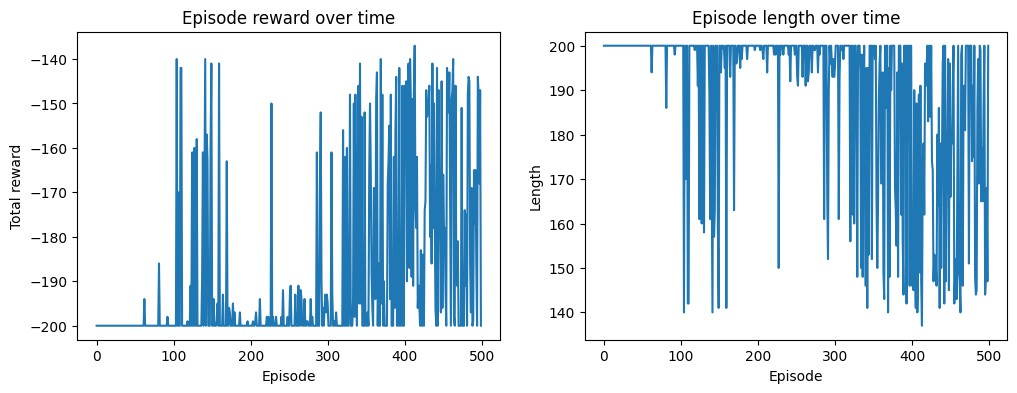

In [11]:
env = create_env("MountainCar-v0", record=True, eps_record=50)
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_feature = 200
lr = 0.03
estimator = Estimator(n_feature, n_state, n_action, lr)

n_episode = 500
q_learning(env, estimator, n_episode, epsilon=0.2, show=True)

In [ ]:
display_video(450)

## **Developing SARSA with linear function approximation**

In general, the SARSA algorithm updates the Q-function based on the following equation:

<br>

$$
\\ \large Q(s, a) ← Q(s, a) + \alpha[r + \gamma Q(s', a') - Q(s, a)]
$$

<br>

>$
 \textit{ s' is the resulting state after taking action a, in state, s;} \\
 \textit{ r is the associated reward;} \\
 \textit{ α is the learning rate; and γ is the discount factor;} \\
 \textit{ a' is the next action by epsilon-greedy policy}
$

 <br>

SARSA with FA has the following error term:

<br>

$$
\large \delta = r + \gamma V_(s_{t+1}) - V(s_t) = r + \gamma V(s', a') - V(s_t)
$$

<br>

Our learning goal is to minimize the error term to zero, which means that the estimated V(s_t) should satisfy the following equation:

 <br>

$$
\large V(s_t) = r + \gamma V(s', a')
$$

In [14]:
def SARSA(env, estimator, n_episode, epsilon=0.2,
          epsilon_decay=.99, min_epsilon=0.05, gamma=1., show=True):
    """
    Implements the SARSA (State-Action-Reward-State-Action) algorithm.

    Args:
        env: The environment object (e.g., OpenAI Gym environment).
        estimator: The estimator object for approximating Q-values.
        n_episode: Number of episodes to train the agent.
        epsilon: Initial epsilon value for epsilon-greedy exploration.
        epsilon_decay: Decay rate for epsilon after each episode.
        gamma: Discount factor for future rewards (default is 1 for undiscounted rewards).
        show: If True, display plots of total rewards and episode lengths.
    Returns:
        None
    """
    n_action = env.action_space.n  # Number of actions in the environment
    length_episode = [0] * n_episode  # Track the length of each episode
    total_reward_episode = [0] * n_episode  # Track total rewards for each episode

    # Loop through the specified number of episodes
    pbar = tqdm(range(n_episode), desc="Episodes")
    for episode in pbar:
        state, _ = env.reset()  # Reset the environment to get the initial state

        # Choose the initial action using the epsilon-greedy strategy
        action = take_action(estimator, state, epsilon, n_action)
        done = False  # Initialize the "done" flag to indicate the episode is not finished

        # Loop through steps of the episode until it terminates
        while not done:
            # Execute the chosen action and observe the next state, reward, and done flag
            next_state, reward, done, _ = env.step(action)

            # Predict Q-values for the next state
            q_values_next = estimator.predict(next_state)

            # Choose the next action using the epsilon-greedy strategy
            next_action = take_action(estimator, next_state, epsilon, n_action)

            # Compute the TD target: reward + discounted Q-value of the next state-action pair
            td_target = reward + gamma * q_values_next[next_action]

            # Update the Q-value estimator using the TD target
            estimator.update(state, action, td_target)

            # Update the current state and action for the next step
            state = next_state
            action = next_action

            # Track the length and total reward for the current episode
            length_episode[episode] += 1
            total_reward_episode[episode] += reward

        # Decay epsilon for the next episode to reduce exploration over time
        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        # Compute and print the average total reward over past 50 completed episodes
        start = episode - 50 if episode > 50 else 0
        avg_tot_reward = np.array(total_reward_episode[start:]).mean()
        pbar.set_description(
            f"Average reward over past 50 episodes: {avg_tot_reward:.2f} | "
            f"ε: {epsilon:.2f}"
        )

    # If `show` is True, plot the rewards and lengths of episodes
    if show:
        fig = plt.figure(figsize=(12, 4))

        # Plot total reward per episode
        fig.add_subplot(1, 2, 1)
        plt.plot(total_reward_episode)
        plt.title('Episode reward over time')
        plt.xlabel('Episode')
        plt.ylabel('Total reward')

        # Plot episode length over time
        fig.add_subplot(1, 2, 2)
        plt.plot(length_episode)
        plt.title('Episode length over time')
        plt.xlabel('Episode')
        plt.ylabel('Length')

        plt.show()

Episodes:   0%|          | 0/500 [00:00<?, ?it/s]

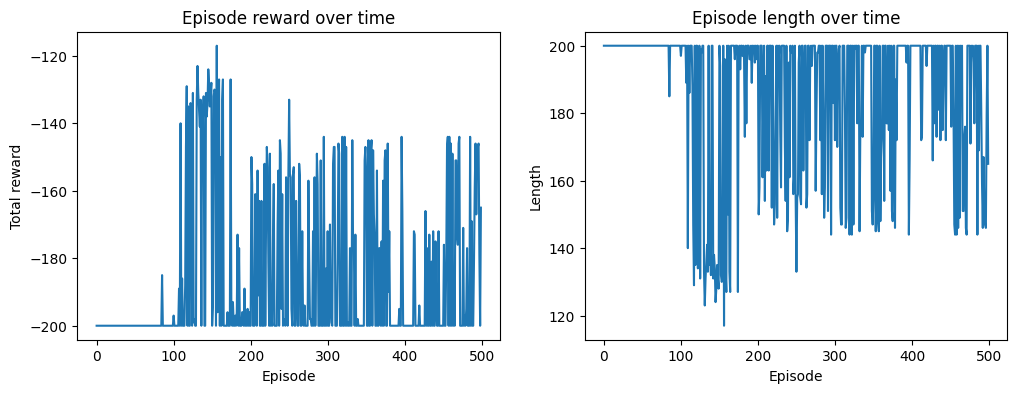

In [16]:
env = create_env("MountainCar-v0", record=True, eps_record=50)
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_feature = 200
lr = 0.03
estimator = Estimator(n_feature, n_state, n_action, lr)

n_episode = 500
SARSA(env, estimator, n_episode, epsilon=0.2, gamma=0.99)

In [17]:
display_video(450)

## **Incorporating batching using experience replay**

we will improve the performance of off-policy Qlearning by incorporating experience replay. also called the **buffer**, or **memory**

**Experience replay** means we store the agent's experiences during an episode instead of running Q-learning.
The learning phase with experience replay becomes two phases:
1. gaining experience
2. updating models based on the experience obtained after an episode finishes.

the experience includes the past state, the action taken, the reward received, and the next state for individual steps in an episode.

In [18]:
from collections import deque
import random

class ReplayBuffer():
    """
    A fixed-size buffer that stores agent experiences for replay.

    Attributes:
        capacity (int): Maximum number of experiences the buffer can hold.
        buffer (deque): A double-ended queue to store experiences with a maximum length of `capacity`.
    """
    def __init__(self, capacity):
        """
        Initialize the ReplayBuffer.

        Args:
            capacity (int): The maximum number of experiences to store in the buffer.
        """
        self.capacity = capacity  # Maximum size of the buffer
        self.buffer = deque(maxlen=self.capacity)  # Create a deque with a fixed maximum size

    def __len__(self):
        """
        Return the current number of experiences stored in the buffer.

        Returns:
            int: Number of elements in the buffer.
        """
        return len(self.buffer)

    def append(self, experience):
        """
        Add a new experience to the buffer.

        If the buffer is full, the oldest experience is automatically removed.

        Args:
            experience (tuple): A single experience (state, action, reward, next_state, done).
        """
        self.buffer.append(experience)

    def sample(self, batch_size):
        """
        Sample a random batch of experiences from the buffer.

        Args:
            batch_size (int): The number of experiences to sample.

        Returns:
            list: A list of randomly sampled experiences from the buffer.
        """
        return random.sample(self.buffer, batch_size)

In [153]:
from tqdm.notebook import tqdm

class Q_learning():
    """
    A Q-learning agent with experience replay.
    """
    def __init__(self, env, estimator, gamma, n_episode, epsilon=0.15,
                 epsilon_decay=0.995, epsilon_min=0.05, batch_size=512, capacity=50_000):
        """
        Initialize the Q-learning agent.

        Args:
            env: The environment (OpenAI Gym compatible).
            estimator: The model used to predict and update Q-values.
            gamma: Discount factor for future rewards.
            n_episode: Total number of episodes for training.
            alpha: Learning rate for Q-value updates.
            epsilon (float): Initial exploration rate for ε-greedy policy (0 ≤ epsilon ≤ 1).
                            Probability of taking a random action.
            epsilon_decay (float): Rate at which epsilon decays each episode (0 < decay ≤ 1).
                            Typical values: 0.995-0.999 for gradual decay.
            epsilon_min (float): Minimum exploration rate. Prevents epsilon from decaying to 0.
                            Suggested: 0.01-0.1 for continued exploration.
            batch_size: Number of experiences sampled from the replay buffer per update.
        """
        self.env = env
        self.estimator = estimator
        self.n_action = env.action_space.n  # Number of possible actions
        self.gamma = gamma  # Discount factor
        self.n_episode = n_episode  # Total number of episodes
        self.epsilon = epsilon  # Initial epsilon for exploration
        self.epsilon_min = epsilon_min  # Minimum epsilon value
        self.epsilon_decay = epsilon_decay  # Epsilon decay rate
        self.buffer = ReplayBuffer(capacity)  # Replay buffer for experience replay
        self.batch_size = batch_size  # Batch size for training
        self.epi = 0  # Current episode index

        # Arrays to track episode lengths and total rewards
        self.length_episode = [] # Number of steps per episode
        self.total_reward_episode = []  # Total reward per episode

        # Ensure the replay buffer is filled with enough samples before training
        target_fill = capacity // 10
        with tqdm(total=target_fill, desc="Filling replay buffer") as pbar:
            while len(self.buffer) < target_fill:
                current_size = len(self.buffer)
                self.play()  # Collect more samples
                new_size = len(self.buffer)
                pbar.update(new_size - current_size)  # Update progress
                # pbar.set_postfix({"Current": len(self.buffer), "Target": target_fill})
                pbar.set_description(f"Filling replay buffer, size: {capacity} | Current: {len(self.buffer)} | Target: {target_fill}")

    def train(self):
        """
        Train the Q-learning agent using experiences from the replay buffer.
        """
        pbar = tqdm(range(self.n_episode), desc='Episodes')
        for episode in pbar:
            # Play an episode and store experiences in the buffer
            self.play(train=True)

            # Sample experiences from the replay buffer and update the Q-values
            for item in self.buffer.sample(self.batch_size):
                states, actions, rewards, next_states, done = item
                self.update(states, actions, rewards, next_states, done)

            # Decay epsilon after each episode (but not below minimum)
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

            # Compute and print the average total reward over past 50 completed episodes
            start = episode - 50 if episode > 50 else 0
            avg_tot_reward = np.array(self.total_reward_episode[start:]).mean()
            pbar.set_description(
                f"Average reward over past 50 episodes: {avg_tot_reward:.2f} | "
                f"ε: {self.epsilon:.2f}"
            )


    def update(self, state, action, reward, next_state, done):
        """
        Perform Q-value update for a given experience.

        Args:
            state: The current state.
            action: The action taken in the current state.
            reward: The reward received after taking the action.
            next_state: The state transitioned to after taking the action.
        """
        # Predict the Q-values for the next state
        Q_next = self.estimator.predict(next_state)

        # # Compute the target Q-value using the Bellman equation
        # td_delta = reward + self.gamma * torch.max(Q_next).item()

        if not done:
            # TD error includes discounted future rewards if the episode is not done
            td_delta = reward + self.gamma * torch.max(Q_next).item()
        else:
            # TD error only includes immediate reward if the episode ends
            td_delta = reward

        # Update the Q-value for the current state-action pair
        self.estimator.update(state, action, td_delta)

    def play(self, train=False):
        """
        Play one episode of the environment.

        Args:
            train (bool): If True, updates the replay buffer and tracks episode statistics.
        """
        # Reset the environment at the start of the episode
        state, _ = self.env.reset()
        done = False  # Flag to indicate if the episode has ended
        length_episode = 0
        total_reward_episode = 0

        # Iterate through the episode until it ends
        while not done:
            # Select an action using the epsilon-greedy policy
            action = self.take_action(self.estimator, state, self.epsilon, self.n_action)

            # Take the chosen action and observe the next state, reward, and done flag
            next_state, reward, done, _ = self.env.step(action)

            if train:
                # Track the length of the episode (number of steps)
                length_episode+= 1

                # Track the total reward for this episode
                total_reward_episode+= reward

            # Store the experience in the replay buffer
            self.buffer.append((state, action, reward, next_state, done))

            # Update the Q-value for the current state-action pair during exploration
            self.update(state, action, reward, next_state, done)

            # Update the current state
            state = next_state

        if train:
            # Increment the episode counter
            self.epi += 1
            self.length_episode.append(length_episode)
            self.total_reward_episode.append(total_reward_episode)


    def take_action(self, estimator, state, epsilon, n_action):
        """
        Select an action using the epsilon-greedy policy.

        Args:
            estimator: The model used to predict Q-values.
            state: The current state.
            epsilon: The current exploration rate.
            n_action: The total number of possible actions.

        Returns:
            int: The selected action.
        """
        if np.random.random() < epsilon:
            # Exploration: Choose a random action
            return torch.randint(0, n_action, (1,)).item()
        else:
            # Exploitation: Choose the action with the highest Q-value for the current state
            Q = estimator.predict(state)
            return torch.argmax(Q).item()

    def log(self):
        """
        Plot and log the rewards and lengths of episodes over time.
        """
        fig = plt.figure(figsize=(12, 4))

        # Plot total reward per episode
        fig.add_subplot(1, 2, 1)
        plt.plot(self.total_reward_episode)
        plt.title('Episode reward over time')
        plt.xlabel('Episode')
        plt.ylabel('Total reward')

        # Plot episode length over time
        fig.add_subplot(1, 2, 2)
        plt.plot(self.length_episode)
        plt.title('Episode length over time')
        plt.xlabel('Episode')
        plt.ylabel('Length')

        plt.show()

In [195]:
# env = create_env("Taxi-v3")
env = create_env("MountainCar-v0", record=True, eps_record=50)
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_feature = 200
lr = 0.03
estimator = Estimator(n_feature, n_state, n_action, lr)

gamma = 0.99
n_episode = 500
epsilon = 0.2
agent = Q_learning(env, estimator, gamma, n_episode, epsilon=epsilon)

Filling replay buffer:   0%|          | 0/5000 [00:00<?, ?it/s]

In [48]:
agent.train()

Episodes:   0%|          | 0/500 [00:00<?, ?it/s]

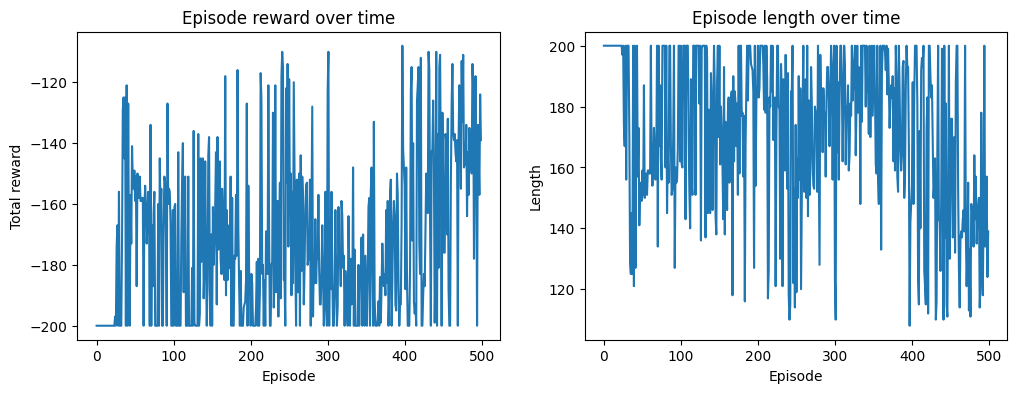

In [49]:
agent.log()

In [50]:
display_video(450)

## **Developing Q-learning with neural network function approximation**

In [158]:
class Estimator2():

    def __init__(self, n_feat, n_hidden, n_state, n_action, lr=0.05):
        # Initialize the estimator with key parameters
        self.n_state = n_state  # Number of states in the environment
        self.n_action = n_action  # Number of possible actions
        self.n_feat = n_feat  # Number of features used for representation
        self.n_hidden = n_hidden  # Number of hidden units in the NN
        self.lr = lr  # Learning rate for optimization

        # Generate Gaussian random features
        self.w, self.b = self._gaussian_function()

        # Create separate models and optimizers for each action
        self.models = []  # List to store models for each action
        self.optimizers = []  # List to store optimizers for each model

        # Define the loss function (Mean Squared Error for regression)
        self.criterion = torch.nn.MSELoss()

        # Initialize a linear regression model and optimizer for each action
        for _ in range(self.n_action):
            model = torch.nn.Sequential(
                torch.nn.Linear(self.n_feat, self.n_hidden),  # Linear model for action
                torch.nn.LayerNorm(self.n_hidden),
                torch.nn.Tanh(),
                torch.nn.Linear(self.n_hidden, 1)
            )
            torch.nn.init.xavier_uniform_(model[0].weight)  # Better initialization
            optimizer = torch.optim.Adam(model.parameters(), self.lr)  # SGD optimizer
            self.models.append(model)  # Append the model to the list
            self.optimizers.append(optimizer)  # Append the optimizer to the list

    def _gaussian_function(self, sigma=.2):
        """
        Generate Gaussian random weights and biases for feature mapping.
        Args:
            sigma: Controls the variance of the Gaussian distribution.
        Returns:
            w: Weight matrix for Gaussian features.
            b: Bias vector for Gaussian features.
        """
        torch.manual_seed(7)  # Set seed for reproducibility
        w = torch.randn((self.n_state, self.n_feat)) * (1 / sigma)  # Random weights from a normal distribution
        b = torch.rand(self.n_feat) * 2 * math.pi  # Random biases from a uniform distribution in [0, 2π]
        return w, b

    def _get_feature(self, s):
        """
        Map a given state to a Gaussian random feature representation.
        Args:
            s: State vector.
        Returns:
            Transformed feature vector.
        """
        arc = torch.matmul(torch.tensor(s).float(), self.w) + self.b  # Compute projection + bias (Matrix product of two tensors)
        features = (2 / self.n_feat) ** .5 * torch.cos(arc)  # Apply cosine transformation
        return (features - features.mean()) / (features.std() + 1e-8)  # Normalize

    def update(self, s, a, y):
        """
        Update the model for a given state, action, and target value.
        Args:
            s: State vector.
            a: Action index (integer).
            y: Target value (scalar).
        """
        features = Variable(self._get_feature(s))  # Compute feature representation
        y_pred = self.models[a](features)  # Predict the target value for the given action
        loss = self.criterion(y_pred, Variable(torch.Tensor([y])))  # Compute MSE loss

        self.optimizers[a].zero_grad()  # Zero out gradients
        loss.backward()  # Backpropagate the error
        self.optimizers[a].step()  # Update the model parameters

    def predict(self, s):
        """
        Predict Q-values for all actions for a given state.
        Args:
            s: State vector.
        Returns:
            Tensor of predicted Q-values for all actions.
        """
        features = self._get_feature(s)  # Compute feature representation
        with torch.no_grad():  # Disable gradient calculation
            return torch.tensor([model(features) for model in self.models])  # Predict for all actions

In [185]:
# env = create_env("Taxi-v3")
env = create_env("MountainCar-v0", record=True, eps_record=50)
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_feature = 512
n_hidden = 352
lr = 0.003
estimator = Estimator2(n_feature, n_hidden, n_state, n_action, lr)

gamma = 0.99
n_episode = 300
epsilon = 0.3
agent = Q_learning(env, estimator, gamma, n_episode, epsilon, epsilon_min = .1, capacity=100000)

Filling replay buffer:   0%|          | 0/10000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/300 [00:00<?, ?it/s]

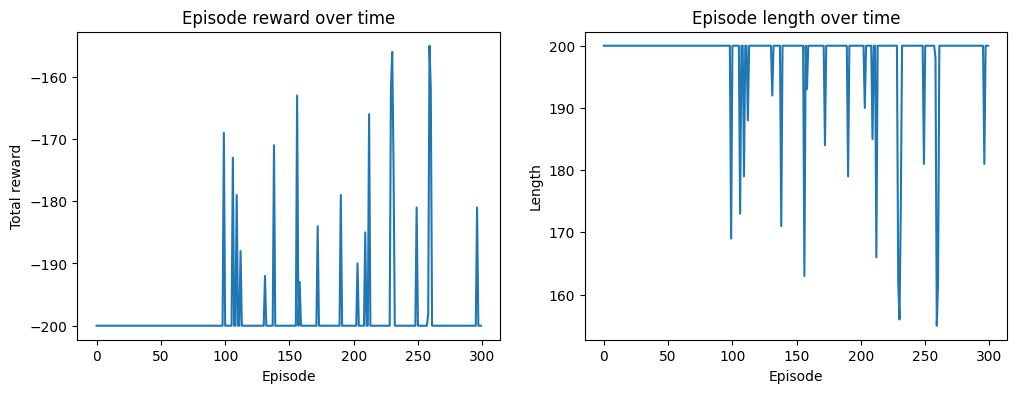

In [186]:
agent.train()
agent.log()

In [187]:
display_video(250)

## **Cart Pole environment**

<img width="400" align="right" src="https://www.gymlibrary.dev/_images/cart_pole.gif">


<br>

<table>
<tr>
    <td><font size="3">Action Space</td>
    <td><font size="3">Discrete(2)</td>
</tr>
<tr>
    <td><font size="3">Observation Shape</td>
    <td><font size="3">(4,))</td>
</tr>
<tr>
    <td><font size="3">Observation High</td>
    <td><font size="3">[4.8 inf 0.42 inf]</td>
</tr>
<tr>
    <td><font size="3">Observation Low</td>
    <td><font size="3">[-4.8 -inf -0.42 -inf]</td>
<tr>
<tr>
    <td><font size="3">Import</td>
    <td><font size="4"><code>gym.make("CartPole-v1")</code></td>
<tr>



In [182]:
env = create_env("CartPole-v1", record = True, eps_record = 50)
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_feature = 512
n_hidden = 352
lr = 0.003
estimator = Estimator2(n_feature, n_hidden, n_state, n_action, lr)

gamma = 0.99
n_episode = 300
epsilon = 0.3
agent = Q_learning(env, estimator, gamma, n_episode, epsilon, epsilon_min = .1, capacity=100000)

Filling replay buffer:   0%|          | 0/10000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/300 [00:00<?, ?it/s]

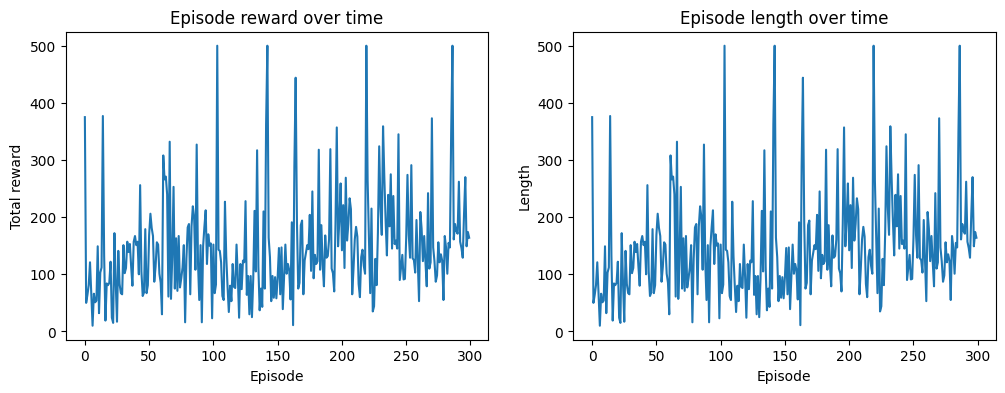

In [183]:
agent.train()
agent.log()

In [184]:
display_video(250)